# Predicting Pop Subgenres

Using a dataset of from Spotify API

GOAL
**Research Question:** Can we predict a pop song's subgenre using its audio features?

**7 Pop Subgenres:**



## Setting up dataset

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# autoreload 
%load_ext autoreload
%autoreload 2

#Setting pandas viewing options
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 300)
pd.set_option('display.width', 1000)

### Importing Datasets

In [2]:
# Import data to Pandas DataFrame
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
test_final = pd.read_csv('data/test_final.csv')

# Split X & y for train, test, and test_final
X_train = train.drop('target', axis=1)
y_train = train['target']

X_test = test.drop('target', axis=1)
y_test = test['target']

X_test_final = test_final.drop('target', axis=1)
y_test_final = test_final['target']


### Scaling datasets

In [3]:
# Standardize with MinMax Scaler
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
X_train_mmscaled = min_max_scaler.fit_transform(X_train)
X_test_mmscaled = min_max_scaler.transform(X_test)
X_test_final_mmscaled = min_max_scaler.transform(X_test_final)

### Starting a score list

In [4]:
model_score = {}

## Logistic Regression

In [5]:
#Computing class weights 
class_names = ['Dance-Pop','Rap-Pop','Folk-Pop', 'Electro-Pop','Rock-Pop', 'Indie-Pop','EDM-Pop']
classes=[1,2,3,4,5,6,7]

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced',classes=classes,y=y_train)
cls_wt = dict(zip(classes,class_weights))

In [6]:
from sklearn.linear_model import LogisticRegression
from scripts import print_metrics

# Perform vanilla logistic regression
logreg_base = LogisticRegression(C = 1e9, 
                                 solver='lbfgs',
                                 multi_class='multinomial', 
                                 max_iter=1000, 
                                 penalty='l2',
                                 class_weight=cls_wt)

logreg_base.fit(X_train_mmscaled, y_train)

pred_logreg_base_train = logreg_base.predict(X_train_mmscaled)
pred_logreg_base_test = logreg_base.predict(X_test_mmscaled)

#Print scores
print_metrics(y_train, pred_logreg_base_train, "Train")
print_metrics(y_test, pred_logreg_base_test, "Test")


Train Accuracy Score: 0.4984272233342865
Test Accuracy Score: 0.5030025736345439


### Tuning Logistic Regression Parameters using Grid Search and Cross Validation

In [7]:
from sklearn.model_selection import GridSearchCV

logreg_GS = LogisticRegression(random_state = 11,
                               multi_class='multinomial', 
                               max_iter=1000)

# Set grid search params
param_grid_logreg = [
    {'penalty':['l1'],
     'solver':['saga'],
     'C':[1e9, 1e5, 1e3, 1, 1e-2],
     'class_weight':[cls_wt,'balanced']
     },
    {'penalty':['l2'],
     'solver':['newton-cg'],
     'C':[1e9, 1e5, 1e3, 1, 1e-2],
     'class_weight':[cls_wt,'balanced']
    }   
]

# Construct grid search
gs_logreg = GridSearchCV(estimator=logreg_GS,
            param_grid=param_grid_logreg,
            scoring='accuracy',
            refit='accuracy',
            cv=5, verbose=2, return_train_score = True,
            n_jobs=-1)

# Fit using grid search
gs_logreg.fit(X_train_mmscaled, y_train)

pred_gs_lr_train = gs_logreg.predict(X_train_mmscaled)
pred_gs_lr_test = gs_logreg.predict(X_test_mmscaled)

best_parameters = gs_logreg.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))


#Print scores
print_metrics(y_train, pred_gs_lr_train, "Train")
print_metrics(y_test, pred_gs_lr_test, "Test")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


Grid Search found the following optimal parameters: 
C: 1000000000.0
class_weight: {1: 0.7974005244555923, 2: 0.7592270950933565, 3: 1.0500713159672697, 4: 1.2655387677553604, 5: 1.081908886998221, 6: 1.4802116402116403, 7: 0.9204448246364414}
penalty: 'l1'
solver: 'saga'
Train Accuracy Score: 0.4984272233342865
Test Accuracy Score: 0.50328853302831


In [8]:
#Save scores
from sklearn.metrics import accuracy_score
model_score['logreg'] = [accuracy_score(y_train, pred_gs_lr_train),
                         accuracy_score(y_test, pred_gs_lr_test)]

## KNN

### Fit KNN Model

In [9]:
from sklearn.neighbors import KNeighborsClassifier


knn1 = KNeighborsClassifier()
knn1.fit(X_train_mmscaled, y_train)
knn1_train_preds = knn1.predict(X_train_mmscaled)
knn1_test_preds = knn1.predict(X_test_mmscaled)

print_metrics(y_train, knn1_train_preds,"Train")
print_metrics(y_test, knn1_test_preds, "Test")

Train Accuracy Score: 0.5868601658564484
Test Accuracy Score: 0.4143551615670575


### Find Best K by Accuracy

In [10]:
from scripts import find_best_k_acc

find_best_k_acc(X_train_mmscaled, y_train, X_test_mmscaled, y_test)

Best Value for k: 27
Accuracy: 0.44895624821275376


### Fit KNN Model w/ Optimized K=27

In [11]:
knn2 = KNeighborsClassifier(n_neighbors=27)
knn2.fit(X_train_mmscaled, y_train)
knn2_train_preds = knn2.predict(X_train_mmscaled)
knn2_test_preds = knn2.predict(X_test_mmscaled)

# Print Accuracy
print_metrics(y_train, knn2_train_preds,"Train")
print_metrics(y_test, knn2_test_preds,"Test")

Train Accuracy Score: 0.4845581927366314
Test Accuracy Score: 0.44895624821275376


In [12]:
#Save scores
model_score['KNN'] = [accuracy_score(y_train, knn2_train_preds),
                      accuracy_score(y_test, knn2_test_preds)]

## Decision Tree Classifier 

In [13]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(criterion="gini", max_depth=5) 
tree_clf.fit(X_train_mmscaled, y_train)
tree_pred = tree_clf.predict(X_train_mmscaled)
tree_pred_test = tree_clf.predict(X_test_mmscaled)

# Print Accuracy
print_metrics(y_train, tree_pred,"Train")
print_metrics(y_test, tree_pred_test,"Test")

Train Accuracy Score: 0.4419502430654847
Test Accuracy Score: 0.4315127251930226


In [14]:
#Save scores
model_score['Tree'] = [accuracy_score(y_train, tree_pred),
                       accuracy_score(y_test, tree_pred_test)]

## Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

#Running a standard random forest 
forest = RandomForestClassifier(n_estimators=100, 
                                max_depth= 5, 
                                bootstrap=True,
                                oob_score=True,
                                n_jobs=-1,
                                random_state=11,
                                class_weight='balanced')

forest.fit(X_train_mmscaled, y_train)

pred_forest = forest.predict(X_train_mmscaled)
pred_forest_test = forest.predict(X_test_mmscaled)

print_metrics(y_train, pred_forest,"Train")
print_metrics(y_test, pred_forest_test,"Test")

Train Accuracy Score: 0.5213039748355733
Test Accuracy Score: 0.5144409493851873


### Random Forest Parameter Tuning

In [16]:
#Using Grid Search and Cross Validation

forest_GS = RandomForestClassifier(random_state = 11,
                                   bootstrap=True,
                                   n_jobs=-1,
                                   oob_score=True,
                                   class_weight='balanced')

 
# Set grid search params
param_grid_forest = [ 
  {'n_estimators': [ 225, 250, 275, 300],
   'criterion': ['entropy'], 
   'max_depth': [6, 8],  
   'min_samples_leaf':[ 1, 10, 20]  
  }
]

# Construct grid search
gs_rf = GridSearchCV(estimator=forest_GS,
            param_grid=param_grid_forest,
            scoring='accuracy',
            refit='accuracy',
            cv=5, verbose=2, return_train_score = True,
            n_jobs=-1)

# Fit using grid search
gs_rf.fit(X_train, y_train)

pred_gs_rf_train = gs_rf.predict(X_train)
pred_gs_rf_test = gs_rf.predict(X_test)


print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

# Best accuracy
print('Best accuracy: %.3f' % gs_rf.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.2min finished


Grid Search found the following optimal parameters: 
C: 1000000000.0
class_weight: {1: 0.7974005244555923, 2: 0.7592270950933565, 3: 1.0500713159672697, 4: 1.2655387677553604, 5: 1.081908886998221, 6: 1.4802116402116403, 7: 0.9204448246364414}
penalty: 'l1'
solver: 'saga'
Best accuracy: 0.533


In [17]:
print_metrics(y_train, pred_gs_rf_train,"Train")
print_metrics(y_test, pred_gs_rf_test,"Test")

Train Accuracy Score: 0.6046611381183872
Test Accuracy Score: 0.5416070917929654


In [18]:
#Save scores
model_score['Forest'] = [accuracy_score(y_train, pred_gs_rf_train),
                         accuracy_score(y_test, pred_gs_rf_test)]

## AdaBoost Classifier

In [19]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_clf = AdaBoostClassifier()
adaboost_clf.fit(X_train_mmscaled, y_train)

# Create predictions
adaboost_train_preds = adaboost_clf.predict(X_train_mmscaled)
adaboost_test_preds = adaboost_clf.predict(X_test_mmscaled)

print_metrics(y_train, adaboost_train_preds, "Train")
print_metrics(y_test, adaboost_test_preds, "Test")

Train Accuracy Score: 0.5030740634829854
Test Accuracy Score: 0.4984272233342865


### AdaBoost Classifier Parameter Tuning

In [20]:
adaboost_GS = AdaBoostClassifier(algorithm='SAMME.R',
                                 random_state=11)
 
# Set grid search params
param_grid_adaboost = [ 
  {'base_estimator':[DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=5)],
   'learning_rate': [ 0.15, 0.1, 0.07],
   'n_estimators': [ 275, 300, 325]
  }
]

# Construct grid search
gs_ab = GridSearchCV(estimator=adaboost_GS,
            param_grid=param_grid_adaboost,
            scoring='accuracy',
            refit='accuracy',
            cv=5, verbose=2, return_train_score = True,
            n_jobs=-1)

# Fit using grid search
gs_ab.fit(X_train_mmscaled, y_train)

#Create predictions
pred_gs_ab_train = gs_ab.predict(X_train_mmscaled)
pred_gs_ab_test = gs_ab.predict(X_test_mmscaled)

#Print scores
print_metrics(y_train, pred_gs_ab_train, "Train")
print_metrics(y_test, pred_gs_ab_test, "Test")

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.2min finished


Train Accuracy Score: 0.5539748355733486
Test Accuracy Score: 0.540177294824135


In [21]:
#Save scores
model_score['AdaBoost'] = [accuracy_score(y_train, pred_gs_ab_train), 
                           accuracy_score(y_test, pred_gs_ab_test)]

## Gradient Boosting

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

gbt_clf = GradientBoostingClassifier()
gbt_clf.fit(X_train_mmscaled, y_train)

# Create predictions
gbt_clf_train_preds = gbt_clf.predict(X_train_mmscaled)
gbt_clf_test_preds = gbt_clf.predict(X_test_mmscaled)

#Print scores
print_metrics(y_train, gbt_clf_train_preds, "Train")
print_metrics(y_test, gbt_clf_test_preds, "Test")

Train Accuracy Score: 0.622748069774092
Test Accuracy Score: 0.5527595081498428


### Tuning Gradient Boosting Parameters using Grid Search and Cross Validation

In [23]:
gb_GS = GradientBoostingClassifier(random_state=11, max_features='auto')

# Set grid search params
param_grid_gboost = [ 
  {'subsample': [0.8],
   'learning_rate': [0.065],
   'n_estimators': [400],
   'max_depth':[2]
  }
]

# Construct grid search
gs_gradboost = GridSearchCV(estimator=gb_GS,
               param_grid=param_grid_gboost,
               scoring='accuracy',
               refit='accuracy',
               cv=5, verbose=2, return_train_score = True,
               n_jobs=-1)

# Fit using grid search
gs_gradboost.fit(X_train_mmscaled, y_train)

pred_gs_gb_train = gs_gradboost.predict(X_train_mmscaled)
pred_gs_gb_test = gs_gradboost.predict(X_test_mmscaled)


# Best parameters
best_parameters = gs_gradboost.best_params_
print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

#Print scores
print_metrics(y_train, pred_gs_gb_train, "Train")
print_metrics(y_test, pred_gs_gb_test, "Test")

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.9s finished


Grid Search found the following optimal parameters: 
learning_rate: 0.065
max_depth: 2
n_estimators: 400
subsample: 0.8
Train Accuracy Score: 0.6212467829568201
Test Accuracy Score: 0.5644838432942522


In [24]:
#Save scores
model_score['Gradient Boost'] = [accuracy_score(y_train, pred_gs_gb_train),
                                 accuracy_score(y_test, pred_gs_gb_test)]

## eXtreme Gradient Boost Classifier (XGBoost)

In [25]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train_mmscaled, y_train)
xgb_pred_train = xgb_clf.predict(X_train_mmscaled)
xgb_pred_test = xgb_clf.predict(X_test_mmscaled)

#Print scores
print_metrics(y_train, xgb_pred_train, "Train")
print_metrics(y_test, xgb_pred_test, "Test")

Train Accuracy Score: 0.5945810694881327
Test Accuracy Score: 0.5478981984558192


### Tuning XGBoost Parameters using Grid Search and Cross Validation

In [26]:
# Tuning XGBoost
from sklearn.model_selection import GridSearchCV

xgb_param_grid = {
    "learning_rate": [0.06,  0.05],
    'max_depth': [2],
    'subsample': [ 0.75, 0.8],
    'n_estimators': [400, 350],
}

grid_xgb_clf = GridSearchCV(xgb_clf, 
                            xgb_param_grid, 
                            scoring='accuracy', 
                            cv=5, 
                            n_jobs=-1)

grid_xgb_clf.fit(X_train_mmscaled, y_train)

pred_gs_gxb_train = grid_xgb_clf.predict(X_train_mmscaled)
pred_gs_gxb_test = grid_xgb_clf.predict(X_test_mmscaled)

best_parameters = grid_xgb_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

#Print scores
print_metrics(y_train, pred_gs_gxb_train, "Train")
print_metrics(y_test, pred_gs_gxb_test, "Test")

Grid Search found the following optimal parameters: 
learning_rate: 0.06
max_depth: 2
n_estimators: 400
subsample: 0.75
Train Accuracy Score: 0.5887189019159279
Test Accuracy Score: 0.5593365742064627


In [27]:
#Save scores
model_score['XGBoost'] = [accuracy_score(y_train, pred_gs_gxb_train), 
                                 accuracy_score(y_test, pred_gs_gxb_test)]

## SVM

In [28]:
from sklearn import svm
svm_clf = svm.SVC(probability=True, random_state=11)
svm_clf.fit(X_train_mmscaled, y_train)

pred_svm_train = gs_logreg.predict(X_train_mmscaled)
pred_svm_test = gs_logreg.predict(X_test_mmscaled)

#Print scores
print_metrics(y_train, pred_svm_train, "Train")
print_metrics(y_test, pred_svm_test, "Test")

Train Accuracy Score: 0.4984272233342865
Test Accuracy Score: 0.50328853302831


### Tuning SVM Parameters using Grid Search and Cross Validation

In [29]:
# Set grid search params
param_grid_svm = [
    {'C': [12], 'kernel': ['linear']},
    {'C': [10], 'gamma': [0.1], 'kernel': ['rbf']},
    {'coef0': [25], 'gamma': [0.03], 'degree': [3], 'kernel': ['poly']},
    {'coef0': [0.01], 'gamma': [0.2], 'kernel': ['sigmoid']}
]


# Construct grid search
gs_svm = GridSearchCV(estimator=svm_clf,
           param_grid=param_grid_svm,
           scoring='accuracy',
           cv=3, verbose=2, return_train_score=True,
                     n_jobs=5)

# Fit using grid search
gs_svm.fit(X_train_mmscaled, y_train)

pred_gs_svm_train = gs_svm.predict(X_train_mmscaled)
pred_gs_svm_test = gs_svm.predict(X_test_mmscaled)

best_parameters = gs_svm.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))


#Print scores
print_metrics(y_train, pred_gs_svm_train, "Train")
print_metrics(y_test, pred_gs_svm_test, "Test")


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  12 | elapsed:   53.9s remaining:   10.8s
[Parallel(n_jobs=5)]: Done  12 out of  12 | elapsed:  1.3min finished


Grid Search found the following optimal parameters: 
coef0: 25
degree: 3
gamma: 0.03
kernel: 'poly'
Train Accuracy Score: 0.5153703174149271
Test Accuracy Score: 0.5104375178724622


In [30]:
#Save scores
model_score['SVM'] = [accuracy_score(y_train, pred_gs_svm_train),
                      accuracy_score(y_test, pred_gs_svm_test)]

## Choosing the best model 

In [31]:
scores = pd.DataFrame(model_score,index=['Train','Test']).T
scores

,Train,Test
logreg,0.498427,0.503289
KNN,0.484558,0.448956
Tree,0.441950,0.431513
Forest,0.604661,0.541607
AdaBoost,0.553975,0.540177
Gradient Boost,0.621247,0.564484
XGBoost,0.588719,0.559337
SVM,0.515370,0.510438


The model fit with eXtreme Gradient Boost Classifier had the highest accuracy rate

## Fitting Test_Final Dataset 

In [40]:
#Create prediction
xgb_pred_test_final = xgb_clf.predict(X_test_final_mmscaled)

#Print accuracy
print_metrics(y_test_final, xgb_pred_test_final, "Final Test")

Final Test Accuracy Score: 0.5489306545690213


### Confusion Matrix

Confusion matrix, without normalization


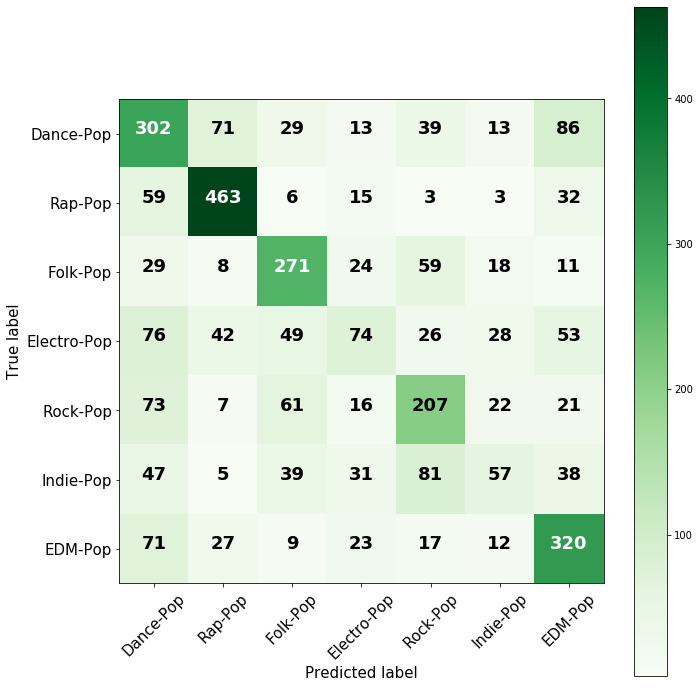

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

from scripts import plot_confusion_matrix 

cnf_matrix = confusion_matrix(y_test_final, xgb_pred_test_final)

plot_confusion_matrix(cm=cnf_matrix, classes=class_names)

### Feature Importance 

<Figure size 720x720 with 0 Axes>

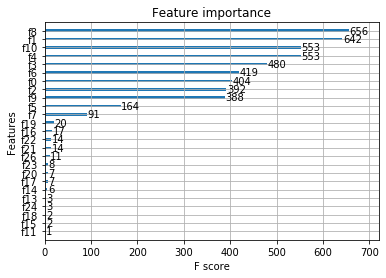

In [41]:
from xgboost import plot_importance

plt.figure(figsize=(10,10))
plot_importance(xgb_clf,height=0.3)

plt.show();

### Presentation Songs 

In [42]:
pres_test = pd.read_csv('data/presentation_test.csv')
pres_test = pres_test.iloc[:,2:]
# pres_test

pres_y = [1,2,3,4,5,6,7]

pred_present = xgb_clf.predict(pres_test)
print(pred_present)

print_metrics(pres_y, pred_present, "Train")

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26'] ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
expected f17, f14, f26, f23, f8, f19, f16, f5, f15, f21, f7, f22, f10, f4, f25, f0, f18, f24, f1, f13, f3, f2, f9, f11, f12, f20, f6 in input data
training data did not have the following fields: liveness, loudness, speechiness, mode, instrumentalness, valence, key, acousticness, danceability, energy, tempo, duration_ms, time_signature